In [2]:
!pwd
!date
!ls

/home/sphere/github/Sphere/Data2013/currents
Чт апр 26 19:50:25 MSK 2018
1currents.txt  currents_2012.txt     Hamamatsu_currents_2013.ipynb
2currents.txt  Currents_2013.ipynb   High_ham.2012.csv
3currents.txt  currents_2013.txt     High_ham.2012.dat
4currents.txt  Hamamatsu_2012.ipynb  High_ham.2013.csv
5currents.txt  Hamamatsu_2013.ipynb  High_ham.dat


In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
from tqdm import tqdm
import math as mt
import numpy as np

from matplotlib import dates
import datetime as dt

In [4]:
plt.rcParams['figure.figsize'] =(8,4)
plt.rcParams['lines.markersize'] = 3.5
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 14

In [5]:
def plot_cur(param):
    fmt = dates.DateFormatter('%H:%M')
    plcol = ['m+-','bx--', 'gs:', 'rd-.', 'co-']

    cur = str(param)

    plt.rcParams['figure.figsize'] = (12,4)
    fig, ax = plt.subplots()
    for i in range(1, 6):
        data = ham[ham.run == i]
        x = [dt.datetime.strptime(i, "%H:%M:%S") for i in data.time]
        y = data[cur]
        label = 'run' + str(i) 
        ax.plot(x, y, plcol[i-1], label = label)

    ax.xaxis.set_major_formatter(fmt)
    ax.set_title(param)
    plt.legend(borderaxespad=0.1)
    plt.grid()

### Чтение данных

In [97]:
def func(N):
    if N < 2691:
        return 1
    if N < 3335:
        return 2
    if N < 3900:
        return 3
    if N < 5133:
        return 4
    return 5

datum = pd.read_csv('currents_2012.txt', header = 0, index_col=0, sep='\t')
params = ['time','cur1']
datum = datum[params]
datum['run'] = datum.apply(lambda x: func(int(x.name)), axis = 1)

In [98]:
datum.tail(2)

,time,cur1,run
N,,,
10333,20:59:52,3.7,5
10334,20:59:52,3.7,5


In [99]:
data = pd.read_csv('High_ham.2012.csv', header = 0, index_col=0)
ham = datum.join(data)
ham.head()

,time,cur1,run,kod,T,HV1,HV10
N,,,,,,,
1756,13:23:15,3.0,1,107,-14.4,-97.7,-1032.0
1757,13:23:42,3.0,1,107,-14.4,-97.7,-1032.0
1758,13:24:00,3.3,1,107,-14.4,-97.7,-1032.0
1759,13:24:04,3.3,1,107,-14.4,-97.7,-1032.0
1760,13:24:21,3.3,1,107,-14.4,-97.7,-1032.0


### Пересчет к высокому с кодом 111

Во четвертом полёте напряжение на ФЭУ0 было изменено с кода 95 на код 111. Приведем все токи к напряжению 111, считая зависимость тока от напряжения линейной. 
Событие 4632 в 15:26 - код высокого  95, ток 2.7.
Событие 4633 в 15:55 - код высокого 111, ток 3.2
Считаем, что за 30 минут ток мало изменился. Приведем все токи к напряжению с кодом 111.

In [100]:
# приведение токов к коду высокого 111
x = [    95,    98,   106,   107, 111,   122,  130]
y = [1.1852, 1.151, 1.058, 1.046, 1.0, 0.873, 0.78]

def func0(kod):
    return y[x.index(kod)]
    
ham['cur0'] = ham.apply(lambda x: x.cur1 * func0(x.kod), axis = 1)

In [108]:
n = 2013 #1884
ham[n:n+3]

,time,cur1,run,kod,T,HV1,HV10,cur0
N,,,,,,,,
4632,15:26:33,2.7,4,95,-10.8,-95.5,-1007.3,3.20004
4633,15:55:38,3.0,4,111,-10.4,-98.0,-1035.2,3.00000
4634,15:55:38,3.0,4,111,-10.4,-98.0,-1035.2,3.00000


In [76]:
ham.kod.value_counts()

130.0    4246
122.0     956
98.0      712
95.0      574
111.0     500
106.0     420
107.0     307
Name: kod, dtype: int64

### Графики

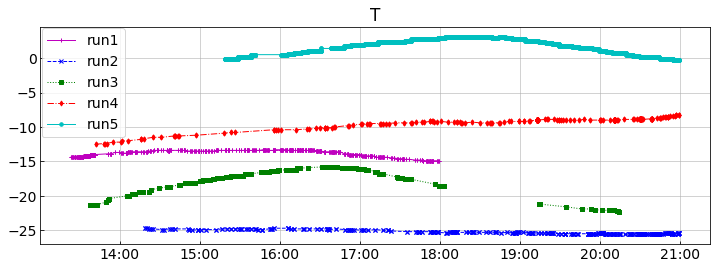

In [40]:
# Температура
plot_cur('T')

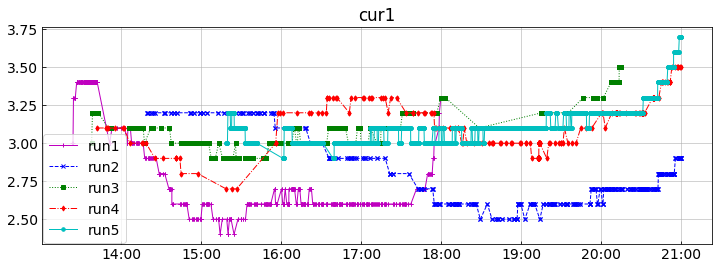

In [42]:
# Зарегистрированные токи
plot_cur('cur1')

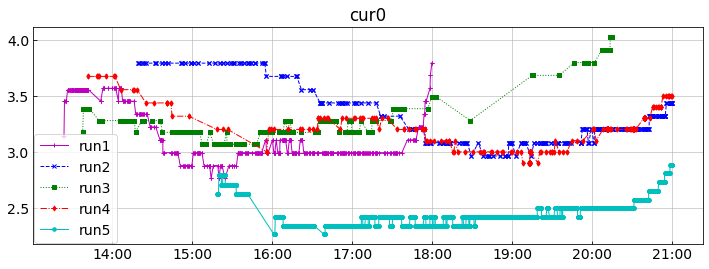

In [103]:
# Токи, приведенные к высокому напряжению с кодом 111
plot_cur('cur0')

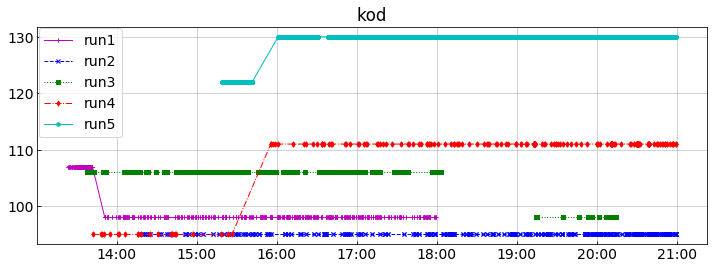

In [43]:
# Код высокого напряжения
plot_cur('kod')

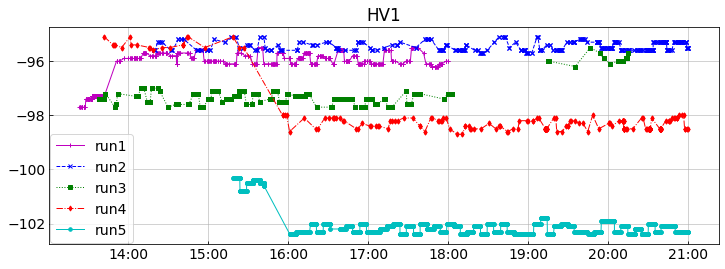

In [44]:
# Напряжение на первом диноде, измеренное
plot_cur('HV1')

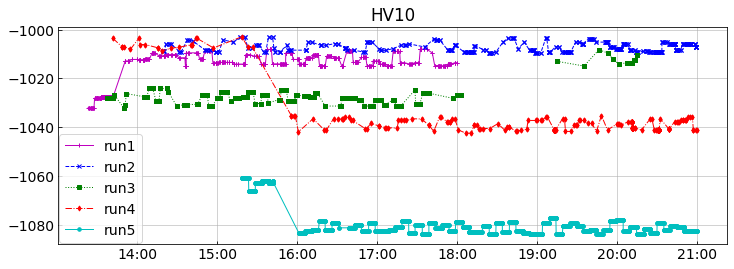

In [45]:
# Напряжение на десятом диноде, посчитанное из измеренного HV1
plot_cur('HV10')

### Коэффициенты для пересчета к напряжению c кодом 111

Point2D(130, 31203/40000)
[[95.0 1.1852]
 [111.0 1.0]
 [130 31203/40000]]


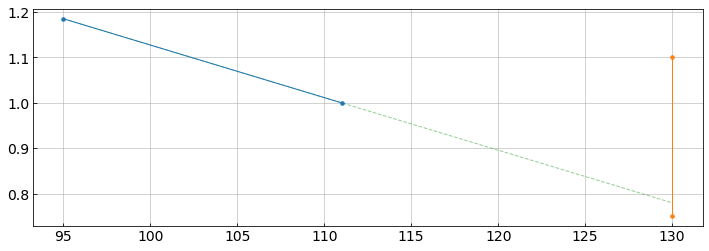

In [110]:
import matplotlib.pyplot as plt
from sympy import Line, Point, Segment
import numpy as np

x1, y1 = [ 95, 111], [1.1852, 1]
x2, y2 = [130, 130], [0.75, 1.1]

# объекты точек
p1, p2, p3, p4 = (Point(x1[0], y1[0]), Point(x1[1], y1[1]),
                  Point(x2[0], y2[0]), Point(x2[1], y2[1]))

# объекты прямых для установления факта пересечения
# объекты отрезков для проверки наличия точки пересечения уже на отрезке
line1, seg1 = Line(p1, p2), Segment(p1, p2)
line2, seg2 = Line(p3, p4), Segment(p3, p4)

intersect = line1.intersection(line2)

l1, = plt.plot(x1, y1, marker='o', zorder=3)
l2, = plt.plot(x2, y2, marker='o', zorder=3)

if intersect:
    pi = intersect[0]
    print(pi)
    if not seg1.contains(pi):
        xydata = l1.get_xydata()
        xydata = np.vstack((xydata, [pi.x, pi.y]))
        print(xydata)
        plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5)
    if not seg2.contains(pi):
        xydata = l2.get_xydata()
        xydata = np.vstack((xydata, [pi.x, pi.y]))
        print(xydata)
        plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5)    
plt.grid()

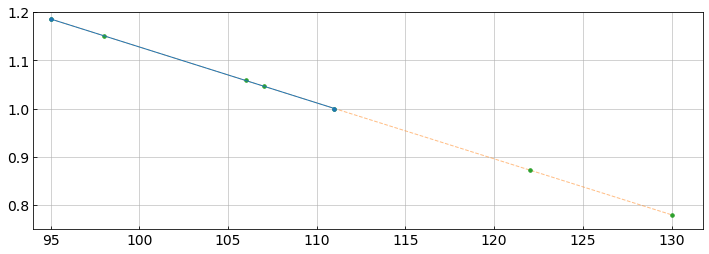

In [111]:
x = [    95,    98,   106,   107,  111,   122,  130]
y = [1.1852, 1.151, 1.058, 1.046,  1.0, 0.873, 0.78]
l1, = plt.plot(x1, y1, marker='o', zorder=3)
plt.plot(xydata[:, 0], xydata[:, 1], '--', alpha=.5) 
plt.plot(x, y, 'o')
plt.xlim(94)
plt.ylim(0.75,1.2)
plt.grid()